In [ ]:
from google.colab import drive
from IPython.display import clear_output

drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!wget https://cloud.haerle.dev/index.php/s/5c9MsFcBHzq4j9Z/download/generated_organamnist_3.npz

--2023-08-24 14:27:40--  https://cloud.haerle.dev/index.php/s/5c9MsFcBHzq4j9Z/download/generated_organamnist_3.npz
Resolving cloud.haerle.dev (cloud.haerle.dev)... 185.104.141.19
Connecting to cloud.haerle.dev (cloud.haerle.dev)|185.104.141.19|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 345400534 (329M) [application/octet-stream]
Saving to: ‘generated_organamnist_3.npz’

generated_organamni 100%[===================>] 329.40M  11.2MB/s    in 30s     

2023-08-24 14:28:10 (11.2 MB/s) - ‘generated_organamnist_3.npz’ saved [345400534/345400534]



In [ ]:
!pip install medmnist
clear_output()

In [ ]:
from resnet import ResNet50
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from sklearn.metrics import classification_report
import pickle
import matplotlib.pyplot as plt
from medmnist import dataset
import numpy as np
import torchvision.transforms as transforms
import random
import os
from torch.utils.data import Dataset

In [ ]:
def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")

set_seed(100)

Random seed set as 100


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 256
EPOCHS = 10
img_size = 28
lr = 0.001

model_store_path = "/content/drive/MyDrive/DLAM/DLAM-Project/models/"

In [ ]:
from torch.utils.data import Dataset
from medmnist.info import INFO, HOMEPAGE, DEFAULT_ROOT
from PIL import Image


class FakeMedMNIST(Dataset):

    flag = "OrganAMNIST".lower()

    def __init__(self,
                 split,
                 transform=None,
                 target_transform=None,
                 download=False,
                 as_rgb=False,
                 root=None):
        ''' dataset
        :param split: 'train', 'val' or 'test', select subset
        :param transform: data transformation
        :param target_transform: target transformation

        '''

        self.info = INFO[self.flag]
        npz_file = np.load("./generated_organamnist_3.npz")

        self.split = split
        self.transform = transform
        self.target_transform = target_transform
        self.as_rgb = as_rgb

        if self.split == 'train':
            self.imgs = npz_file['train_images']
            self.labels = npz_file['train_labels']
        elif self.split == 'val':
            self.imgs = npz_file['val_images']
            self.labels = npz_file['val_labels']
        elif self.split == 'test':
            self.imgs = npz_file['test_images']
            self.labels = npz_file['test_labels']
        else:
            raise ValueError

    def __len__(self):
        return self.imgs.shape[0]

    def __repr__(self):
        '''Adapted from torchvision.ss'''
        _repr_indent = 4
        head = f"Dataset {self.__class__.__name__} ({self.flag})"
        body = [f"Number of datapoints: {self.__len__()}"]
        body.append(f"Root location: {self.root}")
        body.append(f"Split: {self.split}")
        body.append(f"Task: {self.info['task']}")
        body.append(f"Number of channels: {self.info['n_channels']}")
        body.append(f"Meaning of labels: {self.info['label']}")
        body.append(f"Number of samples: {self.info['n_samples']}")
        body.append(f"Description: {self.info['description']}")
        body.append(f"License: {self.info['license']}")

        lines = [head] + [" " * _repr_indent + line for line in body]
        return '\n'.join(lines)


class MedMNIST2D(FakeMedMNIST):

    def __getitem__(self, index):
        '''
        return: (without transform/target_transofrm)
            img: PIL.Image
            target: np.array of `L` (L=1 for single-label)
        '''
        img, target = self.imgs[index], self.labels[index].astype(int)
        img = Image.fromarray(img)

        if self.as_rgb:
            img = img.convert('RGB')

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target

    def save(self, folder, postfix="png", write_csv=True):

        from medmnist.utils import save2d

        save2d(imgs=self.imgs,
               labels=self.labels,
               img_folder=os.path.join(folder, self.flag),
               split=self.split,
               postfix=postfix,
               csv_path=os.path.join(folder, f"{self.flag}.csv") if write_csv else None)

    def montage(self, length=20, replace=False, save_folder=None):
        from medmnist.utils import montage2d

        n_sel = length * length
        sel = np.random.choice(self.__len__(), size=n_sel, replace=replace)

        montage_img = montage2d(imgs=self.imgs,
                                n_channels=self.info['n_channels'],
                                sel=sel)

        if save_folder is not None:
            if not os.path.exists(save_folder):
                os.makedirs(save_folder)
            montage_img.save(os.path.join(save_folder,
                                          f"{self.flag}_{self.split}_montage.jpg"))

        return montage_img

class OrganAMNIST(MedMNIST2D):
    flag = "organamnist"

In [ ]:
dataset_fake = OrganAMNIST(
        # root=data_dir,
        split='train',
        transform=transforms.Compose([
            transforms.Resize(img_size),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])
        ]),
        target_transform=transforms.Lambda(lambda x: x[0]),
        # flag=dataset_name,
        download=True
    )

train_dataloader_fake = torch.utils.data.DataLoader(
    dataset_fake,
    batch_size=batch_size,
    shuffle=True
)

dataset_original = dataset.OrganAMNIST(
        # root=data_dir,
        split='test',
        transform=transforms.Compose([
            transforms.Resize(img_size),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])
        ]),
        target_transform=transforms.Lambda(lambda x: x[0]),
        # flag=dataset_name,
        download=True
    )
test_dataloader = torch.utils.data.DataLoader(
    dataset_original,
    batch_size=batch_size,
    shuffle=False
)

100%|██████████| 38247903/38247903 [00:15<00:00, 2463636.58it/s]


In [ ]:
unique, counts = np.unique(np.array([dataset_fake[i][1] for i in range(len(dataset_fake))]), return_counts=True)
print(np.asarray((unique, counts)).T)

[[   0 5000]
 [   1 5000]
 [   2 5000]
 [   3 5000]
 [   4 5000]
 [   5 5000]
 [   6 5000]
 [   7 5000]
 [   8 5000]
 [   9 5000]
 [  10 5000]]


In [ ]:
unique, counts = np.unique(np.array([dataset_original[i][1] for i in range(len(dataset_original))]), return_counts=True)
print(np.asarray((unique, counts)).T)

[[   0 1036]
 [   1  784]
 [   2  793]
 [   3  785]
 [   4 2064]
 [   5 1965]
 [   6 3285]
 [   7 1747]
 [   8 1813]
 [   9 1622]
 [  10 1884]]


In [ ]:
num_classes = len(train_dataloader_fake.dataset.info["label"])
classes = list(train_dataloader_fake.dataset.info["label"])
model = ResNet50(num_classes=num_classes, channels=1).to(device)

In [ ]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5, last_epoch=-1, verbose=False)


In [ ]:
def training(dataloader, device, model, criterion, scheduler):
    model.train()
    losses = []
    running_loss = 0

    pbar = tqdm(dataloader, unit="batch", desc="Training")
    for inputs, labels in pbar:
        inputs, labels = inputs.to(device), labels.view(-1).to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = sum(losses)/len(losses)
    scheduler.step()

    return model, scheduler, avg_loss

def classify_dataloader(dataloader, device, model):
    model.eval()
    y_pred = []
    y_true = []
    losses = []
    running_loss = 0
    pbar = tqdm(dataloader, unit="batch", desc="Evaluating")

    with torch.no_grad():

        for inputs, labels in pbar:
            inputs, labels = inputs.to(device), labels.view(-1).to(device)
            optimizer.zero_grad()

            outputs = model(inputs)

            labels_predicted = outputs.argmax(1)
            for prediction, label in zip(labels_predicted, labels):
                y_pred.append(int(prediction))
                y_true.append(int(label))

            loss = criterion(outputs, labels)
            losses.append(loss.item())

            running_loss += loss.item()

    avg_loss = sum(losses)/len(losses)
    return y_true, y_pred, avg_loss

In [ ]:
losses = {"train_loss": [],
          "test_loss": [],
          "test_predictions": [],
          "model_path": [],
          "test_true_labels": []}

for epoch in range(1, EPOCHS+1):
    print(f"Processing epoch {epoch}:")
    model, scheduler, avg_loss_train = training(train_dataloader_fake, device, model, criterion, scheduler)
    print(f"Avg train loss: {round(avg_loss_train, 3)}")

    y_true, y_pred, avg_loss_test = classify_dataloader(test_dataloader, device, model)
    losses["train_loss"].append(avg_loss_train)
    print(f"Avg test loss: {round(avg_loss_test, 3)}")

    losses["test_loss"].append(avg_loss_test)
    losses["test_predictions"].append([y_pred])
    losses["test_true_labels"].append([y_true])

    losses["model_path"].append(f"{model_store_path}ResNet50original_epoch_{epoch}")

    torch.save(model, f"{model_store_path}ResNet50original_epoch_{epoch}")
    # Save the losses dictionary
    with open(f"{model_store_path}losses_fake.pkl", "wb") as f:
        pickle.dump(losses, f)
    print("\n"*2)

print('Training Done')

Processing epoch 1:


Training: 100%|██████████| 215/215 [00:30<00:00,  7.09batch/s]


Avg train loss: 0.055


Evaluating: 100%|██████████| 70/70 [00:05<00:00, 12.24batch/s]


Avg test loss: 22.198



Processing epoch 2:


Training: 100%|██████████| 215/215 [00:22<00:00,  9.62batch/s]


Avg train loss: 0.0


Evaluating: 100%|██████████| 70/70 [00:05<00:00, 12.85batch/s]


Avg test loss: 21.224



Processing epoch 3:


Training: 100%|██████████| 215/215 [00:21<00:00,  9.77batch/s]


Avg train loss: 0.0


Evaluating: 100%|██████████| 70/70 [00:05<00:00, 12.44batch/s]


Avg test loss: 21.61



Processing epoch 4:


Training: 100%|██████████| 215/215 [00:22<00:00,  9.72batch/s]


Avg train loss: 0.0


Evaluating: 100%|██████████| 70/70 [00:05<00:00, 12.73batch/s]


Avg test loss: 20.457



Processing epoch 5:


Training: 100%|██████████| 215/215 [00:21<00:00,  9.86batch/s]


Avg train loss: 0.0


Evaluating: 100%|██████████| 70/70 [00:05<00:00, 12.83batch/s]


Avg test loss: 20.697



Processing epoch 6:


Training: 100%|██████████| 215/215 [00:21<00:00,  9.82batch/s]


Avg train loss: 0.0


Evaluating: 100%|██████████| 70/70 [00:05<00:00, 12.92batch/s]


Avg test loss: 21.435



Processing epoch 7:


Training: 100%|██████████| 215/215 [00:21<00:00,  9.81batch/s]


Avg train loss: 0.0


Evaluating: 100%|██████████| 70/70 [00:05<00:00, 12.79batch/s]


Avg test loss: 22.926



Processing epoch 8:


Training: 100%|██████████| 215/215 [00:21<00:00,  9.90batch/s]


Avg train loss: 0.0


Evaluating: 100%|██████████| 70/70 [00:05<00:00, 12.82batch/s]


Avg test loss: 20.523



Processing epoch 9:


Training: 100%|██████████| 215/215 [00:21<00:00,  9.79batch/s]


Avg train loss: 0.0


Evaluating: 100%|██████████| 70/70 [00:05<00:00, 12.62batch/s]


Avg test loss: 21.555



Processing epoch 10:


Training: 100%|██████████| 215/215 [00:21<00:00,  9.85batch/s]


Avg train loss: 0.0


Evaluating: 100%|██████████| 70/70 [00:05<00:00, 12.69batch/s]


Avg test loss: 22.694



Training Done


In [ ]:
file = open(f"{model_store_path}losses_fake.pkl", "rb")
losses = pickle.load(file)

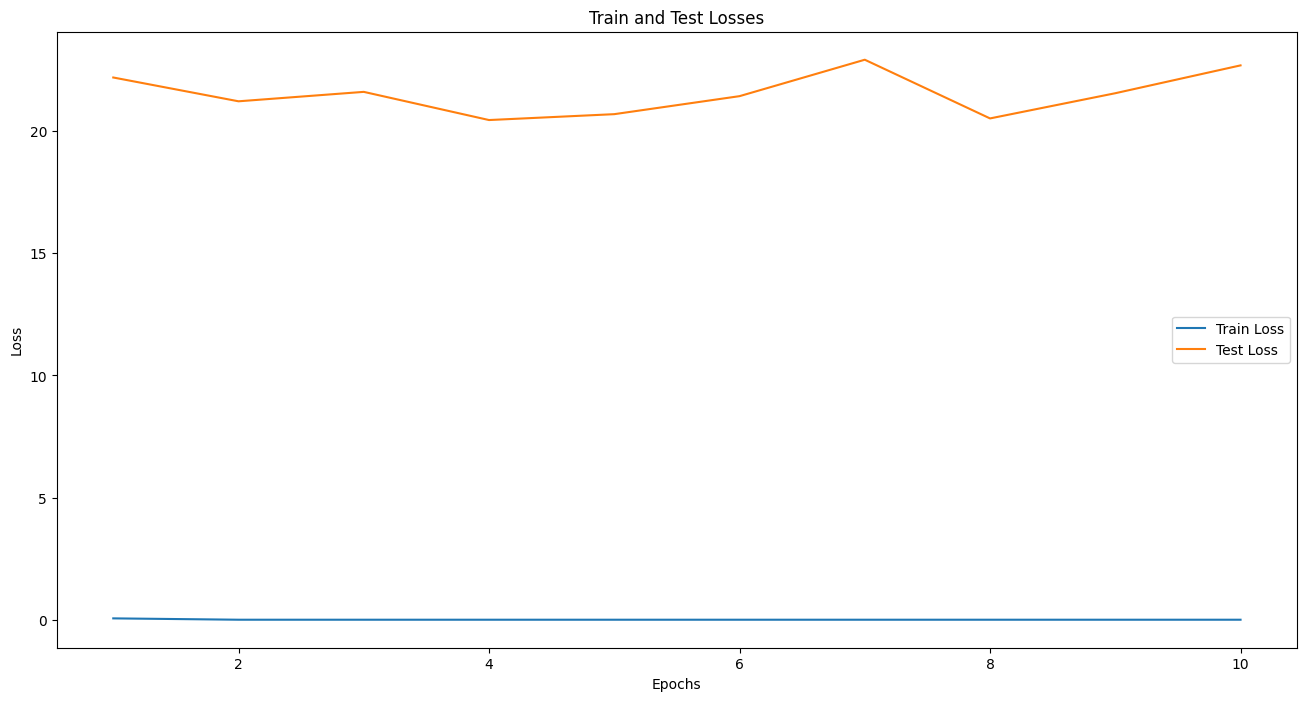

In [ ]:
# Create x-axis values (epochs)
epochs = range(1, len(losses['train_loss']) + 1)

# Set the figure size
plt.figure(figsize=(16, 8))
# Plot train and test losses
plt.plot(epochs, losses['train_loss'], label='Train Loss')
plt.plot(epochs, losses['test_loss'], label='Test Loss')


# Add labels and title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Test Losses')
plt.legend()

# Show the plot
plt.show()

In [ ]:
y_pred_min = losses["test_predictions"][np.argmin(losses["train_loss"])][0]
y_true_min = losses["test_true_labels"][np.argmin(losses["train_loss"])][0]

report = classification_report(y_true_min, y_pred_min)
print(report)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1036
           1       0.04      1.00      0.08       784
           2       0.00      0.00      0.00       793
           3       0.00      0.00      0.00       785
           4       0.00      0.00      0.00      2064
           5       0.00      0.00      0.00      1965
           6       0.00      0.00      0.00      3285
           7       0.00      0.00      0.00      1747
           8       0.00      0.00      0.00      1813
           9       0.00      0.00      0.00      1622
          10       0.00      0.00      0.00      1884

    accuracy                           0.04     17778
   macro avg       0.00      0.09      0.01     17778
weighted avg       0.00      0.04      0.00     17778



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
